# IberLEF - HOMO-LAT25
---

In [91]:
import torch
import torch.nn as nn

from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, AutoModel, AutoConfig
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import ast

In [92]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

Device count: 1
Current device: 0
NVIDIA GeForce RTX 3090


In [93]:
# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [94]:
# Parameters
NUM_CLASSES = 3
MODELS_PATH = "../checkpoints/"

# Model Hyperparameters
MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
WARMUP_STEPS = 0
WEIGHT_DECAY = 0.01

In [95]:
# ENG
paraphrase_col = "paraphrase"
text_col = "translation"

# ESP
# paraphrase_col = "paraphrase_esp"
# text_col = "post content"

In [96]:
# MODEL_NAME = "google-bert/bert-base-uncased"
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
# MODEL_NAME = "FacebookAI/roberta-base"
# MODEL_NAME = "tabularisai/multilingual-sentiment-analysis"
# MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
# MODEL_NAME = "google-bert/bert-base-multilingual-uncased"
# MODEL_NAME = "JonatanGk/roberta-base-bne-finetuned-hate-speech-offensive-spanish"
# MODEL_NAME = "pysentimiento/robertuito-sentiment-analysis"

id2label = {0: 'NEG', 1: 'NEU', 2: 'POS'}

label2id = {'NEG': 0, 'NEU': 1, 'POS': 2}

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_CLASSES, id2label=id2label, label2id=label2id)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [97]:
model.config

RobertaConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [98]:
class CustomBERTModel(nn.Module):
    def __init__(self, pretrained_model_name, num_labels):
        super(CustomBERTModel, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrained_model_name, num_labels=num_labels)
        self.feedforward = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(self.bert.config.hidden_size // 2, self.bert.config.hidden_size // 4),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(self.bert.config.hidden_size // 4, num_labels)

    def forward(self, input_ids, attention_mask, labels=None, token_type_ids=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Get the last hidden state
        last_hidden_state = output.last_hidden_state
        # Use the CLS token representation (first token)
        cls_token = last_hidden_state[:, 0, :]
        # Pass through feedforward layers
        x = self.feedforward(cls_token)
        # Final classification layer
        logits = self.fc(x)
        return logits

In [99]:
# model = CustomBERTModel(MODEL_NAME, NUM_CLASSES)
# model.to(device)

### Tokenizer

In [100]:
print("Max sequence length:", tokenizer.model_max_length)
tokenizer.model_max_length = MAX_LEN
print("Max sequence length:", tokenizer.model_max_length)

Max sequence length: 1000000000000000019884624838656
Max sequence length: 256


In [101]:
# Print first 10 ids of tokenizer
print(tokenizer.convert_ids_to_tokens(range(10)))

['<s>', '<pad>', '</s>', '<unk>', '.', 'Ġthe', ',', 'Ġto', 'Ġand', 'Ġof']


### Load datasets

In [102]:
data_path = "../data/"

In [103]:
data = pd.read_csv(data_path + "data.csv")

In [104]:
# train_df = pd.read_csv(train_path)
# val_df = pd.read_csv(val_path)
# test_df = pd.read_csv(test_path)
# dev_df = pd.read_csv(dev_path)


# columns = ['country', 'keyword', 'post content', 'label', 'embeddings',
#        'translation', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase',
#        'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2',
#        'embedding_paraphrase_esp1', 'embedding_paraphrase_esp2']

# # Create columns if they don't exist
# for col in columns:
#     if col not in train_df.columns:
#         train_df[col] = None
#     if col not in val_df.columns:
#         val_df[col] = None
#     if col not in test_df.columns:
#         test_df[col] = None
#     if col not in dev_df.columns:
#         dev_df[col] = None

# # Order dataframe columns
# train_df = train_df[columns]
# val_df = val_df[columns]
# test_df = test_df[columns]
# dev_df = dev_df[columns]

# print(train_df.columns)
# print(val_df.columns)
# print(test_df.columns)
# print(dev_df.columns)

In [105]:
# # Join all dataframes
# data = pd.concat([train_df, val_df, test_df, dev_df], ignore_index=True)
# data.shape

In [106]:
data.head()

,Unnamed: 0,keyword,post content,label,embeddings,translation,embeddings_ingles,absa,absa_esp,paraphrase,paraphrase_esp,embedding_paraphrase1,embedding_paraphrase2,embedding_paraphrase_esp1,embedding_paraphrase_esp2,country
0,Argentina,trans,ni idea quin es yo conozco a elon muse que es ...,1,[ 1.03526646e-02 -3.98133248e-02 4.34677452e-...,no idea who that is i know elon muse who is a ...,[-6.73531964e-02 -7.03806058e-02 3.57527845e-...,[CLS] no idea who that is i know elon muse who...,[CLS] ni idea quin es yo conozco a elon muse q...,"['I have no clue who that is, but I know Elon ...","['No tengo ni la menor idea de quién es, pero ...",[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
1,Argentina,gay,quise decir que generaciones no tan viejas est...,0,[ 1.48003269e-02 1.87553223e-02 -4.54413369e-...,i meant to say that generations not so old are...,[ 8.76692608e-02 1.54911121e-02 -6.65056929e-...,[CLS] i meant to say that generations not so o...,[CLS] quise decir que generaciones no tan viej...,"[""I was trying to convey that not-so-old gener...",['Lo que quiero expresar es que hay generacion...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-4.96738590e-02 8.76008645e-02 9.10560042e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
2,Argentina,transgénero,somos una pareja trans tenemos una relacin pol...,1,[ 6.02439139e-03 -4.05745283e-02 3.04297004e-...,we are a trans couple we have a polyamorous an...,[-1.39014676e-01 -3.52461934e-02 -6.17404003e-...,[CLS] we are a trans couple we have a polyamor...,[CLS] somos una pareja trans tenemos una relac...,"[""We are a trans couple with a polyamorous and...",['Somos una pareja transgénero y tenemos una r...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-4.96738590e-02 8.76008645e-02 9.10560042e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
3,Argentina,lesbiana,epidemia el caso de la lesbiana fumando fue ha...,1,[ 1.32222874e-02 -1.37489401e-02 4.94725667e-...,epidemic the case of the lesbian smoking was a...,[ 3.90458480e-02 6.92736730e-03 5.75472973e-...,[CLS] epidemic the case of the lesbian smoking...,[CLS] epidemia el caso de la lesbiana fumando ...,['epidemic the situation with the lesbian smok...,['la situación con la lesbiana fumando ocurrió...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
4,Argentina,trans,la joven y la trans seducian clientes y la git...,1,[ 0.00305685 -0.01683133 0.01658298 -0.002807...,the young woman and the trans seduced clients ...,[-5.73628880e-02 1.41364560e-01 -7.25603327e-...,[CLS] the young woman and the trans seduced cl...,[CLS] la joven y la trans seducian clientes y ...,['The young lady and the transgender person wo...,['la chica y la trans atraían a los clientes m...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN


In [107]:
# Keyword to lowercase
data["keyword"] = data["keyword"].str.lower()

# Text and paraphrase to lowercase
data[paraphrase_col] = data[paraphrase_col].str.lower()
data[text_col] = data[text_col].str.lower()

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7207 entries, 0 to 7206
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 7207 non-null   object
 1   keyword                    7207 non-null   object
 2   post content               7207 non-null   object
 3   label                      7207 non-null   int64 
 4   embeddings                 7207 non-null   object
 5   translation                7207 non-null   object
 6   embeddings_ingles          7207 non-null   object
 7   absa                       5764 non-null   object
 8   absa_esp                   5764 non-null   object
 9   paraphrase                 7207 non-null   object
 10  paraphrase_esp             7207 non-null   object
 11  embedding_paraphrase1      7207 non-null   object
 12  embedding_paraphrase2      7207 non-null   object
 13  embedding_paraphrase_esp1  7207 non-null   object
 14  embeddin

In [109]:
data["keyword"].value_counts()

keyword
trans            2249
gay              1848
lgbt              989
gays              466
bisexual          268
lesbiana          258
lesbianas         168
travesti          161
travestis         131
transexual        123
asexual           119
queer              82
bisexuales         79
transexuales       72
transgénero        57
transgenero        45
pansexual          43
asexuales          20
intersexual        13
pansexuales         7
intersexuales       6
queers              3
Name: count, dtype: int64

In [110]:
num = 3
word = "queers"

# Get an example where keyword is "trans"
aux = data[["translation", "keyword"]][data["keyword"] == word].head(num)

# Reset index
aux = aux.reset_index(drop=True)

for i in range(num):
    print("Text", i + 1)
    print(aux["translation"][i])
    print()

Text 1
no because they are still biological women  ergo las you can call them trans men or whatever you want honestly but what im getting at is that only female sex individuals are central in radical feminism 

Text 2
i dont think the discussion should be about whether the paper has value or not because that paper is surely useful to someone it has to do with the fact that the role of the state is simply to manage taxpayers money and if taxpayers consider opening a dining hall as a priority over a paper on queers no one can say that this is not democratic

i feel sorry for the person who studied sociology for  years and now doesnt know what to do without their papers at conicet but thats the reality in fact they have better chances of getting funding if its privatized now if no one is interested in financing it well thats just the rules of the game

Text 3
if she had said, "i won't watch 'the whale' because i consider it fatphobic," it would have been generally accepted; we all like di

In [111]:
# Translate Keyword to English
def translate_keyword(keyword):
    if keyword == "lesbiana":
        return "lesbian"
    elif keyword == "lesbianas":
        return "lesbians"
    elif keyword == "travesti":
        return "transvestite"
    elif keyword == "travestis":
        return "transvestites"
    elif keyword == "transexual":
        return "transsexual"
    elif keyword == "transexuales":
        return "transsexuals"
    elif keyword == "bisexuales":
        return "bisexuals"
    elif keyword == "transgenero" or keyword == "transgénero":
        return "transgender"
    elif keyword == "asexuales":
        return "asexuals"
    elif keyword == "intersexual" or keyword == "intersexuales":
        return "intersex"
    elif keyword == "pansexuales":
        return "pansexuals"
    else:
        return keyword
    
# Translate dataset
data["keyword"] = data["keyword"].apply(translate_keyword)

# Add a space before the keyword in the keyword column
data["keyword"] = data["keyword"].apply(lambda x: " " + x)

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7207 entries, 0 to 7206
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Unnamed: 0                 7207 non-null   object
 1   keyword                    7207 non-null   object
 2   post content               7207 non-null   object
 3   label                      7207 non-null   int64 
 4   embeddings                 7207 non-null   object
 5   translation                7207 non-null   object
 6   embeddings_ingles          7207 non-null   object
 7   absa                       5764 non-null   object
 8   absa_esp                   5764 non-null   object
 9   paraphrase                 7207 non-null   object
 10  paraphrase_esp             7207 non-null   object
 11  embedding_paraphrase1      7207 non-null   object
 12  embedding_paraphrase2      7207 non-null   object
 13  embedding_paraphrase_esp1  7207 non-null   object
 14  embeddin

In [113]:
data.head()

,Unnamed: 0,keyword,post content,label,embeddings,translation,embeddings_ingles,absa,absa_esp,paraphrase,paraphrase_esp,embedding_paraphrase1,embedding_paraphrase2,embedding_paraphrase_esp1,embedding_paraphrase_esp2,country
0,Argentina,trans,ni idea quin es yo conozco a elon muse que es ...,1,[ 1.03526646e-02 -3.98133248e-02 4.34677452e-...,no idea who that is i know elon muse who is a ...,[-6.73531964e-02 -7.03806058e-02 3.57527845e-...,[CLS] no idea who that is i know elon muse who...,[CLS] ni idea quin es yo conozco a elon muse q...,"['i have no clue who that is, but i know elon ...","['No tengo ni la menor idea de quién es, pero ...",[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
1,Argentina,gay,quise decir que generaciones no tan viejas est...,0,[ 1.48003269e-02 1.87553223e-02 -4.54413369e-...,i meant to say that generations not so old are...,[ 8.76692608e-02 1.54911121e-02 -6.65056929e-...,[CLS] i meant to say that generations not so o...,[CLS] quise decir que generaciones no tan viej...,"[""i was trying to convey that not-so-old gener...",['Lo que quiero expresar es que hay generacion...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-4.96738590e-02 8.76008645e-02 9.10560042e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
2,Argentina,transgender,somos una pareja trans tenemos una relacin pol...,1,[ 6.02439139e-03 -4.05745283e-02 3.04297004e-...,we are a trans couple we have a polyamorous an...,[-1.39014676e-01 -3.52461934e-02 -6.17404003e-...,[CLS] we are a trans couple we have a polyamor...,[CLS] somos una pareja trans tenemos una relac...,"[""we are a trans couple with a polyamorous and...",['Somos una pareja transgénero y tenemos una r...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-4.96738590e-02 8.76008645e-02 9.10560042e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
3,Argentina,lesbian,epidemia el caso de la lesbiana fumando fue ha...,1,[ 1.32222874e-02 -1.37489401e-02 4.94725667e-...,epidemic the case of the lesbian smoking was a...,[ 3.90458480e-02 6.92736730e-03 5.75472973e-...,[CLS] epidemic the case of the lesbian smoking...,[CLS] epidemia el caso de la lesbiana fumando ...,['epidemic the situation with the lesbian smok...,['la situación con la lesbiana fumando ocurrió...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN
4,Argentina,trans,la joven y la trans seducian clientes y la git...,1,[ 0.00305685 -0.01683133 0.01658298 -0.002807...,the young woman and the trans seduced clients ...,[-5.73628880e-02 1.41364560e-01 -7.25603327e-...,[CLS] the young woman and the trans seduced cl...,[CLS] la joven y la trans seducian clientes y ...,['the young lady and the transgender person wo...,['la chica y la trans atraían a los clientes m...,[-9.28104371e-02 2.67270450e-02 2.41023470e-...,[-6.51732311e-02 4.97170277e-02 3.17783616e-...,[ 1.69905182e-02 -1.14093013e-02 -2.88800877e-...,[ 0.03842558 0.02231733 -0.05300364 -0.027510...,NaN


In [114]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED, stratify=data['label'])
# train_df, val_df = train_test_split(train_df, test_size=1/8, random_state=RANDOM_SEED, stratify=train_df['label'])

# Copy test_df to val_df
val_df = test_df.copy()

train_df.columns

Index(['Unnamed: 0', 'keyword', 'post content', 'label', 'embeddings',
       'translation', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase',
       'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2',
       'embedding_paraphrase_esp1', 'embedding_paraphrase_esp2', 'country'],
      dtype='object')

In [115]:
# Reset all indices
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [116]:
# Rename column 'translation' to 'text'
train_df = train_df.rename(columns={text_col: 'text'})
val_df = val_df.rename(columns={text_col: 'text'})
test_df = test_df.rename(columns={text_col: 'text'})

In [117]:
from DataAugDataset import DataAugDataset

# Create datasets
random_text = 1
random_remove = False
random_order = False
train_dataset = DataAugDataset(train_df["text"].values,
                               train_df["keyword"].values,
                               train_df[paraphrase_col].values, 
                               train_df["label"].values, 
                               tokenizer, 
                               MAX_LEN,
                               random_text=random_text,
                               random_remove=random_remove, 
                               random_order=random_order)

In [118]:
from datasets import Dataset, DatasetDict

raw_datasets = DatasetDict({
    # "train": Dataset.from_pandas(train_df, preserve_index=False),
    "validation": Dataset.from_pandas(val_df, preserve_index=False),
    "test": Dataset.from_pandas(test_df, preserve_index=False),
})
raw_datasets

DatasetDict({
    validation: Dataset({
        features: ['Unnamed: 0', 'keyword', 'post content', 'label', 'embeddings', 'text', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase', 'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2', 'embedding_paraphrase_esp1', 'embedding_paraphrase_esp2', 'country'],
        num_rows: 721
    })
    test: Dataset({
        features: ['Unnamed: 0', 'keyword', 'post content', 'label', 'embeddings', 'text', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase', 'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2', 'embedding_paraphrase_esp1', 'embedding_paraphrase_esp2', 'country'],
        num_rows: 721
    })
})

In [119]:
train_df["label"].value_counts()

label
1    3654
0    2190
2     642
Name: count, dtype: int64

In [120]:
val_df["label"].value_counts()

label
1    406
0    244
2     71
Name: count, dtype: int64

In [121]:
test_df["label"].value_counts()

label
1    406
0    244
2     71
Name: count, dtype: int64

In [122]:
from sklearn.utils.class_weight import compute_class_weight

train_labels = train_df["label"]
class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(class_weights)

tensor([0.9872, 0.5917, 3.3676], device='cuda:0')


In [123]:
def tokenize_function(examples):
    return tokenizer(examples["text"], examples["keyword"], padding="max_length", truncation=True, max_length=MAX_LEN)

# Apply the tokenizer to the dataset
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# Inspect tokenized samples
print(tokenized_datasets["test"][0]["input_ids"])
# Ids to tokens
print(tokenizer.convert_ids_to_tokens(tokenized_datasets["test"][0]["input_ids"]))

Map: 100%|██████████| 721/721 [00:00<00:00, 8024.60 examples/s]

[0, 9981, 28744, 29, 33, 17325, 27109, 7, 6225, 4260, 8, 97, 31580, 658, 1403, 37808, 2088, 12876, 939, 4443, 45365, 596, 51, 241, 342, 89, 2, 2, 47147, 29, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
['<s>', 'trans', 'sexual', 's', 'Ġhave', 'Ġstatistical', 'Ġtendencies', 'Ġto', 'Ġcommit', 'Ġsuicide', 'Ġand', 'Ġother', 'Ġmessed', 'up', 'Ġself', 'destruct', 'ive', 

In [124]:
# Remove unnecessary columns
rem_cols = ['Unnamed: 0', 'country', 'keyword', 'post content', 'text', 'embeddings', 'embeddings_ingles', 'absa', 'absa_esp', 'paraphrase', 'paraphrase_esp', 'embedding_paraphrase1', 'embedding_paraphrase2', 'embedding_paraphrase_esp2', 'embedding_paraphrase_esp1']
# tokenized_datasets = tokenized_datasets.remove_columns(rem_cols)
tokenized_datasets["validation"] = tokenized_datasets["validation"].remove_columns(rem_cols)
tokenized_datasets["test"] = tokenized_datasets["test"].remove_columns(rem_cols)
# Rename column 'label' to 'labels'
tokenized_datasets = tokenized_datasets.rename_column('label', 'labels')
tokenized_datasets

DatasetDict({
    validation: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 721
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 721
    })
})

In [125]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    train_dataset, shuffle=True, batch_size=BATCH_SIZE, collate_fn=data_collator
)
val_dataloader = DataLoader(
    tokenized_datasets["validation"], shuffle=False, batch_size=BATCH_SIZE, collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_datasets["test"], shuffle=False, batch_size=BATCH_SIZE, collate_fn=data_collator
)

print("Train dataloader length:", len(train_dataloader))
print("Validation dataloader length:", len(val_dataloader))
print("Test dataloader length:", len(test_dataloader))

Train dataloader length: 406
Validation dataloader length: 46
Test dataloader length: 46


In [126]:
for param in model.parameters():
   param.requires_grad = True

# Freeze all layers except the classifier
# for param in list(model.parameters())[:-20]:
#     param.requires_grad = False

for param in model.parameters():
    print(param.requires_grad)

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### Model without fine-tuning

In [127]:
model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        y_pred_test.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        y_true_test.extend(batch["labels"].cpu().tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

print(classification_report(y_true_test, y_pred_test, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.45      0.70      0.55       244
         NEU       0.68      0.51      0.59       406
         POS       0.37      0.18      0.25        71

    accuracy                           0.55       721
   macro avg       0.50      0.47      0.46       721
weighted avg       0.57      0.55      0.54       721



### Fine-tuning

In [128]:
from transformers import get_scheduler

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

loss_func = nn.CrossEntropyLoss(weight=class_weights)
# loss_func = nn.CrossEntropyLoss()

num_epochs = EPOCHS
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

4060


In [129]:
from tqdm.auto import tqdm

train_losses = []
val_losses = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0 
    num_train_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        
        # Accumulate loss
        loss = loss_func(logits, batch["labels"])
        # loss = outputs.loss
        epoch_train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        lr_scheduler.step()
        
        num_train_batches += 1

        progress_bar.update(1)

    # Compute average training loss for the epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Run validation
    model.eval()
    epoch_val_loss = 0
    num_val_batches = 0

    y_preds_val = []
    y_trues_val = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            try:
                logits = outputs.logits
            except:
                logits = outputs

            loss = loss_func(logits, batch["labels"])
            # loss = outputs.loss

            epoch_val_loss += loss.item()
            num_val_batches += 1

            y_preds_val.extend(torch.argmax(logits, dim=-1).cpu().tolist())
            y_trues_val.extend(batch["labels"].cpu().tolist())

    # Calculate f1 score
    y_preds_val = np.array(y_preds_val)
    y_trues_val = np.array(y_trues_val)
    f1_val = f1_score(y_trues_val, y_preds_val, average='macro')    

    avg_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs:<10} Train Loss: {avg_train_loss:<10.4f} Val Loss: {avg_val_loss:<10.4f} Macro F1: {f1_val:.4f}")

    # Save model
    try:
        model.save_pretrained(MODELS_PATH + f"epoch_{epoch + 1}")
    except:
        torch.save(model.state_dict(), MODELS_PATH + f"epoch_{epoch + 1}.pt")


100%|██████████| 4510/4510 [58:31<00:00,  1.28it/s]

Epoch 1/10         Train Loss: 1.0030     Val Loss: 0.9391     Macro F1: 0.4744


Epoch 2/10         Train Loss: 0.8563     Val Loss: 0.9311     Macro F1: 0.5441


Epoch 3/10         Train Loss: 0.7368     Val Loss: 0.9397     Macro F1: 0.5470


Epoch 4/10         Train Loss: 0.6204     Val Loss: 1.2164     Macro F1: 0.5327


Epoch 5/10         Train Loss: 0.5145     Val Loss: 1.3894     Macro F1: 0.5534


Epoch 6/10         Train Loss: 0.4173     Val Loss: 1.2527     Macro F1: 0.5368


Epoch 7/10         Train Loss: 0.3491     Val Loss: 1.4831     Macro F1: 0.5346


Epoch 8/10         Train Loss: 0.2895     Val Loss: 1.6695     Macro F1: 0.5458


Epoch 9/10         Train Loss: 0.2611     Val Loss: 1.7343     Macro F1: 0.5502


Epoch 10/10         Train Loss: 0.2096     Val Loss: 1.8542     Macro F1: 0.5529


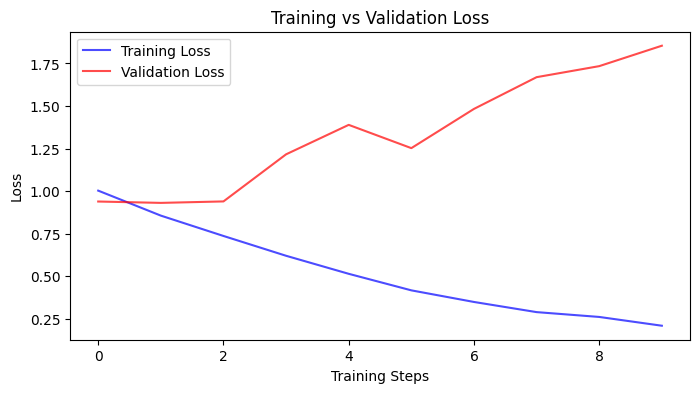

In [130]:
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss", color="blue", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", color="red", alpha=0.7)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [131]:
# Load model
model_name = "epoch_7"
model = AutoModelForSequenceClassification.from_pretrained(MODELS_PATH + model_name)
# model = CustomBERTModel(MODEL_NAME, NUM_CLASSES)
# model.load_state_dict(torch.load(MODELS_PATH + model_name + ".pt"))

model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Validation Evaluation

In [132]:
model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs

        y_pred_val.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        y_true_val.extend(batch["labels"].cpu().tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)

print(classification_report(y_true_val, y_pred_val, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.55      0.58      0.57       244
         NEU       0.70      0.67      0.68       406
         POS       0.35      0.37      0.36        71

    accuracy                           0.61       721
   macro avg       0.53      0.54      0.53       721
weighted avg       0.61      0.61      0.61       721



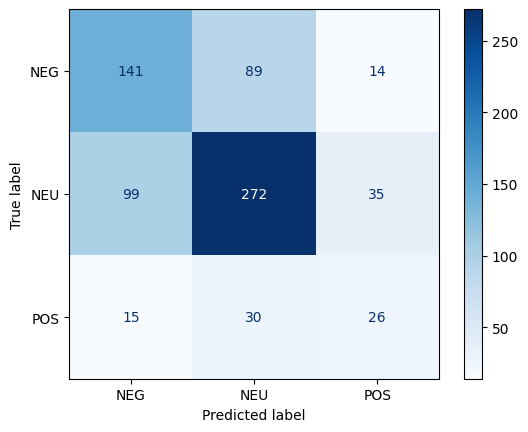

In [133]:
# Confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)

### Test Evaluation

In [134]:
model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        y_pred_test.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        y_true_test.extend(batch["labels"].cpu().tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

print(classification_report(y_true_test, y_pred_test, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.55      0.58      0.57       244
         NEU       0.70      0.67      0.68       406
         POS       0.35      0.37      0.36        71

    accuracy                           0.61       721
   macro avg       0.53      0.54      0.53       721
weighted avg       0.61      0.61      0.61       721



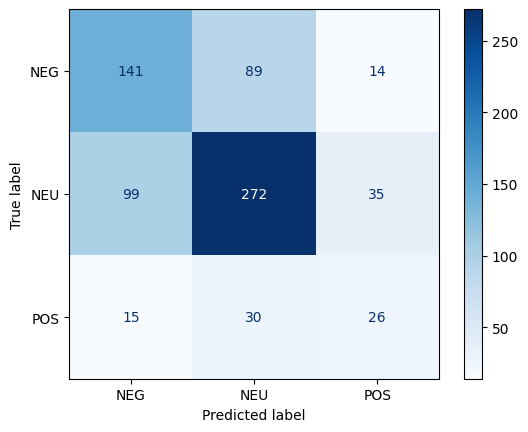

In [135]:
# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)

### Train results

In [136]:
model.eval()

y_pred_train = []
y_true_train = []
with torch.no_grad(): 
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        try:
            logits = outputs.logits
        except:
            logits = outputs
        y_pred_train.extend(torch.argmax(logits, dim=-1).cpu().tolist())
        y_true_train.extend(batch["labels"].cpu().tolist())

y_pred_train = np.array(y_pred_train)
y_true_train = np.array(y_true_train)

print(classification_report(y_true_train, y_pred_train, target_names=id2label.values()))

              precision    recall  f1-score   support

         NEG       0.89      0.91      0.90      2190
         NEU       0.94      0.90      0.92      3654
         POS       0.82      0.98      0.89       642

    accuracy                           0.91      6486
   macro avg       0.88      0.93      0.90      6486
weighted avg       0.91      0.91      0.91      6486



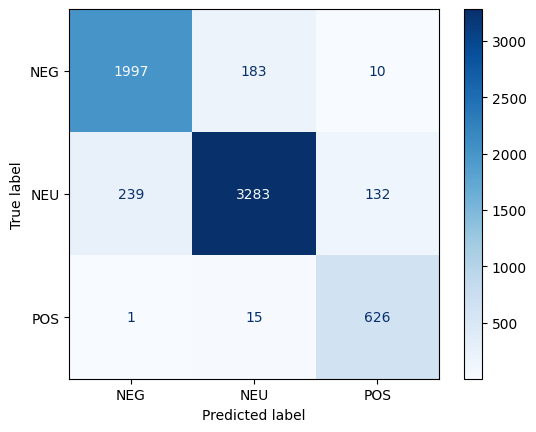

In [137]:
# Confusion matrix
cm = confusion_matrix(y_true_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)

## Predictions

In [138]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODELS_PATH + model_name)
# model = CustomBERTModel(MODEL_NAME, NUM_CLASSES)
# model.load_state_dict(torch.load(MODELS_PATH + model_name + ".pt"))
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [139]:
mapping = {0: 'NEG', 1: 'NEU', 2: 'POS'}

In [140]:
# Predict test sample
def predict_sample(model, tokenizer, sample_text, keyword):
    """
    Predict the sentiment of a sample text
    """
    inputs = tokenizer(sample_text, keyword, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LEN)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    inputs["labels"] = None

    with torch.no_grad():
        outputs = model(**inputs)
        try:
            logits = outputs.logits
        except:
            logits = outputs
    
    probabilities = torch.softmax(logits, dim=-1)
    
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    predicted_label = mapping[predicted_class]
    
    return predicted_label, probabilities[0].cpu().numpy()

In [141]:
# test_idx = 40
test_idx = 2

text_col = "text"
input_text = test_df[text_col][test_idx]
input_keyword = test_df["keyword"][test_idx]

# Get paraphrased samples
samples = ast.literal_eval(test_df[paraphrase_col][test_idx])
samples=list(samples)
paraphrase_text1 = samples[0]
paraphrase_text2 = samples[1]

real_label = test_df['label'][test_idx]
real_label = mapping[real_label]
print("Input text:", input_text)
print("Real label:", real_label)
print("Paraphrase 1:", paraphrase_text1)
print("Paraphrase 2:", paraphrase_text2)
print()

predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_keyword)
print("Predicted label:", predicted_label)
print("Probabilities:", probabilities)
print()

predicted_label1, probabilities = predict_sample(model, tokenizer, paraphrase_text1, input_keyword)
print("Predicted label para1:", predicted_label1)
print("Probabilities:", probabilities)
print()

predicted_label2, probabilities = predict_sample(model, tokenizer, paraphrase_text2, input_keyword)
print("Predicted label para2:", predicted_label2)
print("Probabilities:", probabilities)
print()

predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)
print("Final predicted label:", predicted_label)


Input text: there is some truth to it especially when mentioning aristotle aristotle was a disciple of plato and both came from a profound philosophical school that began with socrates 

nowadays socrates is mentioned as the creator of modern law the humanities philosophy and a bunch of other things

its as if socrates were the first enlightened one

but if socrates were alive we would all be burning hitler was a suckling baby compared to socrates

moreover hitler read some books by socrates and literally said no no we cant do this what this guy says is ultranazi

for example hitler said that not all men in the world could be germans but all could be nazis

socrates on the other hand said that to be greek it wasnt enough just to be born in greece you also had to speak walk behave and look greek

and those who werent greek were beasts they can come to greece he said and if they can leave well see

we all know that socrates was condemned to death for being homosexual or not

well no that

### Ensemble predicions

              precision    recall  f1-score   support

         NEG       0.61      0.58      0.59       244
         NEU       0.70      0.70      0.70       406
         POS       0.30      0.35      0.33        71

    accuracy                           0.63       721
   macro avg       0.54      0.54      0.54       721
weighted avg       0.63      0.63      0.63       721



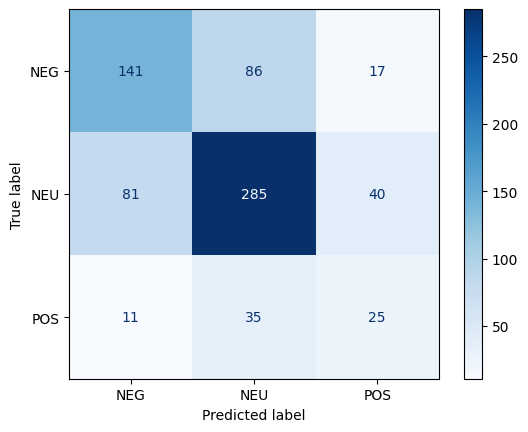

In [142]:
y_pred_test = []
y_true_test = []

for i in range(len(test_df)):
    input_text = test_df[text_col][i]
    input_keyword = test_df["keyword"][i]
    
    # Get paraphrased samples
    samples = ast.literal_eval(test_df[paraphrase_col][i])
    samples=list(samples)
    paraphrase_text1 = samples[0]
    paraphrase_text2 = samples[1]

    real_label = test_df['label'][i]
    real_label = mapping[real_label]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_keyword)
    predicted_label1, probabilities1 = predict_sample(model, tokenizer, paraphrase_text1, input_keyword)
    predicted_label2, probabilities2 = predict_sample(model, tokenizer, paraphrase_text2, input_keyword)

    if predicted_label != predicted_label1 and predicted_label != predicted_label2 and predicted_label1 != predicted_label2:
        labels = [predicted_label, predicted_label1, predicted_label2]
        label1_score = max(probabilities)
        label2_score = max(probabilities1)
        label3_score = max(probabilities2)
        scores = {label1_score: predicted_label, label2_score: predicted_label1, label3_score: predicted_label2}
        final_label = max(scores.keys())
        predicted_label = scores[final_label]
    else:
        # Get the most frequent label
        predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)
    y_pred_test.append(predicted_label)
    y_true_test.append(real_label)

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

print(classification_report(y_true_test, y_pred_test, target_names=id2label.values()))
# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=id2label.values())
disp.plot(cmap=plt.cm.Blues)

### Task 1

In [143]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODELS_PATH + model_name)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [144]:
# Read task1 data
task1_df = pd.read_csv(data_path + "augmented_dataset_task1.csv")

In [145]:
task1_df.head()

,id,country,keyword,post content,translation,paraphrase
0,A1642,Argentina,asexual,"demisexualidad del sufijo en inglés demi-, «a ...","Demisexuality, from the English suffix demi-, ...","['Demisexuality, derived from the English pref..."
1,A1114,Argentina,asexual,"a ver bro, te cuento algo peor? fui a tomar al...","Let's see, bro, let me tell you something wors...","[""Let's see, man, let me share something even ..."
2,A4434,Argentina,asexual,"pensé y no, acá se da a entender que está mira...","I thought and no, it is understood here that i...","[""I considered it, and no, it's clear that it'..."
3,A1431,Argentina,asexual,¿que tal les fue en las reuniones de ex alumno...,How did it go for you at the reunions of the e...,['How did things turn out for you at your elem...
4,A4436,Argentina,asexual,creo que el creador afirmó que era `asexual` e...,I believe the creator stated that they were 'a...,"[""I think the creator mentioned being 'asexual..."


In [146]:
task1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3588 entries, 0 to 3587
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3588 non-null   object
 1   country       3588 non-null   object
 2   keyword       3588 non-null   object
 3   post content  3588 non-null   object
 4   translation   3588 non-null   object
 5   paraphrase    3588 non-null   object
dtypes: object(6)
memory usage: 168.3+ KB


In [147]:
preds_task1 = []

for i in range(len(task1_df)):
    input_text = task1_df["translation"][i]
    input_keyword = task1_df["keyword"][i]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_keyword)

    preds_task1.append(predicted_label)

task1_df["single_preds"] = preds_task1

In [148]:
task1_df.head()

,id,country,keyword,post content,translation,paraphrase,single_preds
0,A1642,Argentina,asexual,"demisexualidad del sufijo en inglés demi-, «a ...","Demisexuality, from the English suffix demi-, ...","['Demisexuality, derived from the English pref...",NEU
1,A1114,Argentina,asexual,"a ver bro, te cuento algo peor? fui a tomar al...","Let's see, bro, let me tell you something wors...","[""Let's see, man, let me share something even ...",NEG
2,A4434,Argentina,asexual,"pensé y no, acá se da a entender que está mira...","I thought and no, it is understood here that i...","[""I considered it, and no, it's clear that it'...",NEU
3,A1431,Argentina,asexual,¿que tal les fue en las reuniones de ex alumno...,How did it go for you at the reunions of the e...,['How did things turn out for you at your elem...,NEU
4,A4436,Argentina,asexual,creo que el creador afirmó que era `asexual` e...,I believe the creator stated that they were 'a...,"[""I think the creator mentioned being 'asexual...",NEU


In [149]:
ensemble_preds_task1 = []

for i in range(len(task1_df)):
    input_text = task1_df["translation"][i]
    input_keyword = task1_df["keyword"][i]
    
    # Get paraphrased samples
    samples = ast.literal_eval(task1_df[paraphrase_col][i])
    samples=list(samples)
    paraphrase_text1 = samples[0]
    paraphrase_text2 = samples[1]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_keyword)
    predicted_label1, probabilities1 = predict_sample(model, tokenizer, paraphrase_text1, input_keyword)
    predicted_label2, probabilities2 = predict_sample(model, tokenizer, paraphrase_text2, input_keyword)

    if predicted_label != predicted_label1 and predicted_label != predicted_label2 and predicted_label1 != predicted_label2:
        labels = [predicted_label, predicted_label1, predicted_label2]
        label1_score = max(probabilities)
        label2_score = max(probabilities1)
        label3_score = max(probabilities2)
        scores = {label1_score: predicted_label, label2_score: predicted_label1, label3_score: predicted_label2}
        final_label = max(scores.keys())
        predicted_label = scores[final_label]
    else:
        # Get the most frequent label
        predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)

    ensemble_preds_task1.append(predicted_label)

task1_df["ensemble_preds"] = ensemble_preds_task1

In [150]:
task1_df.head()

,id,country,keyword,post content,translation,paraphrase,single_preds,ensemble_preds
0,A1642,Argentina,asexual,"demisexualidad del sufijo en inglés demi-, «a ...","Demisexuality, from the English suffix demi-, ...","['Demisexuality, derived from the English pref...",NEU,NEU
1,A1114,Argentina,asexual,"a ver bro, te cuento algo peor? fui a tomar al...","Let's see, bro, let me tell you something wors...","[""Let's see, man, let me share something even ...",NEG,NEG
2,A4434,Argentina,asexual,"pensé y no, acá se da a entender que está mira...","I thought and no, it is understood here that i...","[""I considered it, and no, it's clear that it'...",NEU,NEU
3,A1431,Argentina,asexual,¿que tal les fue en las reuniones de ex alumno...,How did it go for you at the reunions of the e...,['How did things turn out for you at your elem...,NEU,NEU
4,A4436,Argentina,asexual,creo que el creador afirmó que era `asexual` e...,I believe the creator stated that they were 'a...,"[""I think the creator mentioned being 'asexual...",NEU,NEU


In [151]:
# Single preds dataframe
task1_df_single = task1_df[["id", "single_preds"]]
task1_df_single = task1_df_single.rename(columns={"single_preds": "label"})
task1_df_single

,id,label
0,A1642,NEU
1,A1114,NEG
2,A4434,NEU
3,A1431,NEU
4,A4436,NEU
...,...,...
3583,C2173,NEG
3584,C2166,NEG
3585,C2132,NEG
3586,C2170,NEG


In [152]:
# Ensemble preds dataframe
task1_df_ensemble = task1_df[["id", "ensemble_preds"]]
task1_df_ensemble = task1_df_ensemble.rename(columns={"ensemble_preds": "label"})
task1_df_ensemble

,id,label
0,A1642,NEU
1,A1114,NEG
2,A4434,NEU
3,A1431,NEU
4,A4436,NEU
...,...,...
3583,C2173,NEG
3584,C2166,NEG
3585,C2132,NEG
3586,C2170,NEG


In [153]:
# Save dataframes
task1_df_single.to_csv(data_path + "task1_preds_single.csv", index=False)
task1_df_ensemble.to_csv(data_path + "task1_preds_ensemble.csv", index=False)

### Task 2

In [154]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODELS_PATH + model_name)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [155]:
# Read task1 data
task2_df = pd.read_csv(data_path + "augmented_dataset_task2.csv")

In [156]:
task2_df.head()

,id,country,keyword,post content,translation,paraphrase
0,R0000,Uruguay,gay,"creo q es esta, la de u r gay y otra más que n...","I think it's this one, the ""u r gay"" and anoth...","['I believe it\'s this one, the ""you are gay"" ..."
1,R0001,Uruguay,transgénero,que tal peligroso es ser gay/trans? les tengo ...,How dangerous is it to be gay/trans? I have a ...,"[""How risky is it to be gay/trans? I've got a ..."
2,R0002,Uruguay,transexual,es un mundo de diferencia entre ser homosexual...,There is a world of difference between being h...,"[""There’s a significant distinction between be..."
3,R0003,Uruguay,lesbiana,te cuento mi perspectiva como lesbiana viviend...,I'll share my perspective as a lesbian living ...,"[""I'll give my viewpoint as a lesbian living i..."
4,R0004,Uruguay,transexuales,"no es peligroso, en general. pueden sufrir dis...","It's not dangerous, in general. They may suffe...","[""It's not risky overall. They might face disc..."


In [157]:
task2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5475 entries, 0 to 5474
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            5475 non-null   object
 1   country       5475 non-null   object
 2   keyword       5475 non-null   object
 3   post content  5475 non-null   object
 4   translation   5475 non-null   object
 5   paraphrase    5475 non-null   object
dtypes: object(6)
memory usage: 256.8+ KB


In [158]:
preds_task2 = []

for i in range(len(task2_df)):
    input_text = task2_df["translation"][i]
    input_keyword = task2_df["keyword"][i]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_keyword)

    preds_task2.append(predicted_label)

task2_df["single_preds"] = preds_task2

In [159]:
task2_df.head()

,id,country,keyword,post content,translation,paraphrase,single_preds
0,R0000,Uruguay,gay,"creo q es esta, la de u r gay y otra más que n...","I think it's this one, the ""u r gay"" and anoth...","['I believe it\'s this one, the ""you are gay"" ...",NEU
1,R0001,Uruguay,transgénero,que tal peligroso es ser gay/trans? les tengo ...,How dangerous is it to be gay/trans? I have a ...,"[""How risky is it to be gay/trans? I've got a ...",NEU
2,R0002,Uruguay,transexual,es un mundo de diferencia entre ser homosexual...,There is a world of difference between being h...,"[""There’s a significant distinction between be...",NEG
3,R0003,Uruguay,lesbiana,te cuento mi perspectiva como lesbiana viviend...,I'll share my perspective as a lesbian living ...,"[""I'll give my viewpoint as a lesbian living i...",NEU
4,R0004,Uruguay,transexuales,"no es peligroso, en general. pueden sufrir dis...","It's not dangerous, in general. They may suffe...","[""It's not risky overall. They might face disc...",POS


In [160]:
ensemble_preds_task2 = []

for i in range(len(task2_df)):
    input_text = task2_df["translation"][i]
    input_keyword = task2_df["keyword"][i]
    
    # Get paraphrased samples
    samples = ast.literal_eval(task2_df[paraphrase_col][i])
    samples=list(samples)
    paraphrase_text1 = samples[0]
    paraphrase_text2 = samples[1]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_keyword)
    predicted_label1, probabilities1 = predict_sample(model, tokenizer, paraphrase_text1, input_keyword)
    predicted_label2, probabilities2 = predict_sample(model, tokenizer, paraphrase_text2, input_keyword)

    if predicted_label != predicted_label1 and predicted_label != predicted_label2 and predicted_label1 != predicted_label2:
        labels = [predicted_label, predicted_label1, predicted_label2]
        label1_score = max(probabilities)
        label2_score = max(probabilities1)
        label3_score = max(probabilities2)
        scores = {label1_score: predicted_label, label2_score: predicted_label1, label3_score: predicted_label2}
        final_label = max(scores.keys())
        predicted_label = scores[final_label]
    else:
        # Get the most frequent label
        predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)

    ensemble_preds_task2.append(predicted_label)

task2_df["ensemble_preds"] = ensemble_preds_task2

In [161]:
task2_df.head()

,id,country,keyword,post content,translation,paraphrase,single_preds,ensemble_preds
0,R0000,Uruguay,gay,"creo q es esta, la de u r gay y otra más que n...","I think it's this one, the ""u r gay"" and anoth...","['I believe it\'s this one, the ""you are gay"" ...",NEU,NEU
1,R0001,Uruguay,transgénero,que tal peligroso es ser gay/trans? les tengo ...,How dangerous is it to be gay/trans? I have a ...,"[""How risky is it to be gay/trans? I've got a ...",NEU,NEU
2,R0002,Uruguay,transexual,es un mundo de diferencia entre ser homosexual...,There is a world of difference between being h...,"[""There’s a significant distinction between be...",NEG,NEG
3,R0003,Uruguay,lesbiana,te cuento mi perspectiva como lesbiana viviend...,I'll share my perspective as a lesbian living ...,"[""I'll give my viewpoint as a lesbian living i...",NEU,NEU
4,R0004,Uruguay,transexuales,"no es peligroso, en general. pueden sufrir dis...","It's not dangerous, in general. They may suffe...","[""It's not risky overall. They might face disc...",POS,POS


In [162]:
# Single preds dataframe
task2_df_single = task2_df[["id", "single_preds"]]
task2_df_single = task2_df_single.rename(columns={"single_preds": "label"})
task2_df_single

,id,label
0,R0000,NEU
1,R0001,NEU
2,R0002,NEG
3,R0003,NEU
4,R0004,POS
...,...,...
5470,Q0081,NEU
5471,Q0100,NEG
5472,B0036,NEU
5473,L0024,NEG


In [163]:
# Ensemble preds dataframe
task2_df_ensemble = task2_df[["id", "ensemble_preds"]]
task2_df_ensemble = task2_df_ensemble.rename(columns={"ensemble_preds": "label"})
task2_df_ensemble

,id,label
0,R0000,NEU
1,R0001,NEU
2,R0002,NEG
3,R0003,NEU
4,R0004,POS
...,...,...
5470,Q0081,NEU
5471,Q0100,NEG
5472,B0036,NEU
5473,L0024,NEG


In [164]:
# Save dataframes
task2_df_single.to_csv(data_path + "task2_preds_single.csv", index=False)
task2_df_ensemble.to_csv(data_path + "task2_preds_ensemble.csv", index=False)

In [165]:
task1_df_single["label"].value_counts()

label
NEU    1877
NEG    1424
POS     287
Name: count, dtype: int64

In [166]:
task1_df_ensemble["label"].value_counts()

label
NEU    1954
NEG    1322
POS     312
Name: count, dtype: int64

In [167]:
task2_df_single["label"].value_counts()

label
NEU    2978
NEG    1852
POS     645
Name: count, dtype: int64

In [168]:
task2_df_ensemble["label"].value_counts()


label
NEU    3050
NEG    1730
POS     695
Name: count, dtype: int64